In [157]:
import numpy as np
import random
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *
import matplotlib.pyplot as plt
import numpy as np

In [158]:
#3-coloring vertex coloring problem using grover algorithm (np-problem in classical computer, still np in this algorithm but 
#improves the bruce-force algorithm by (theoretically) square-rooting numbers of iterations)

In [159]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [160]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [161]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [162]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

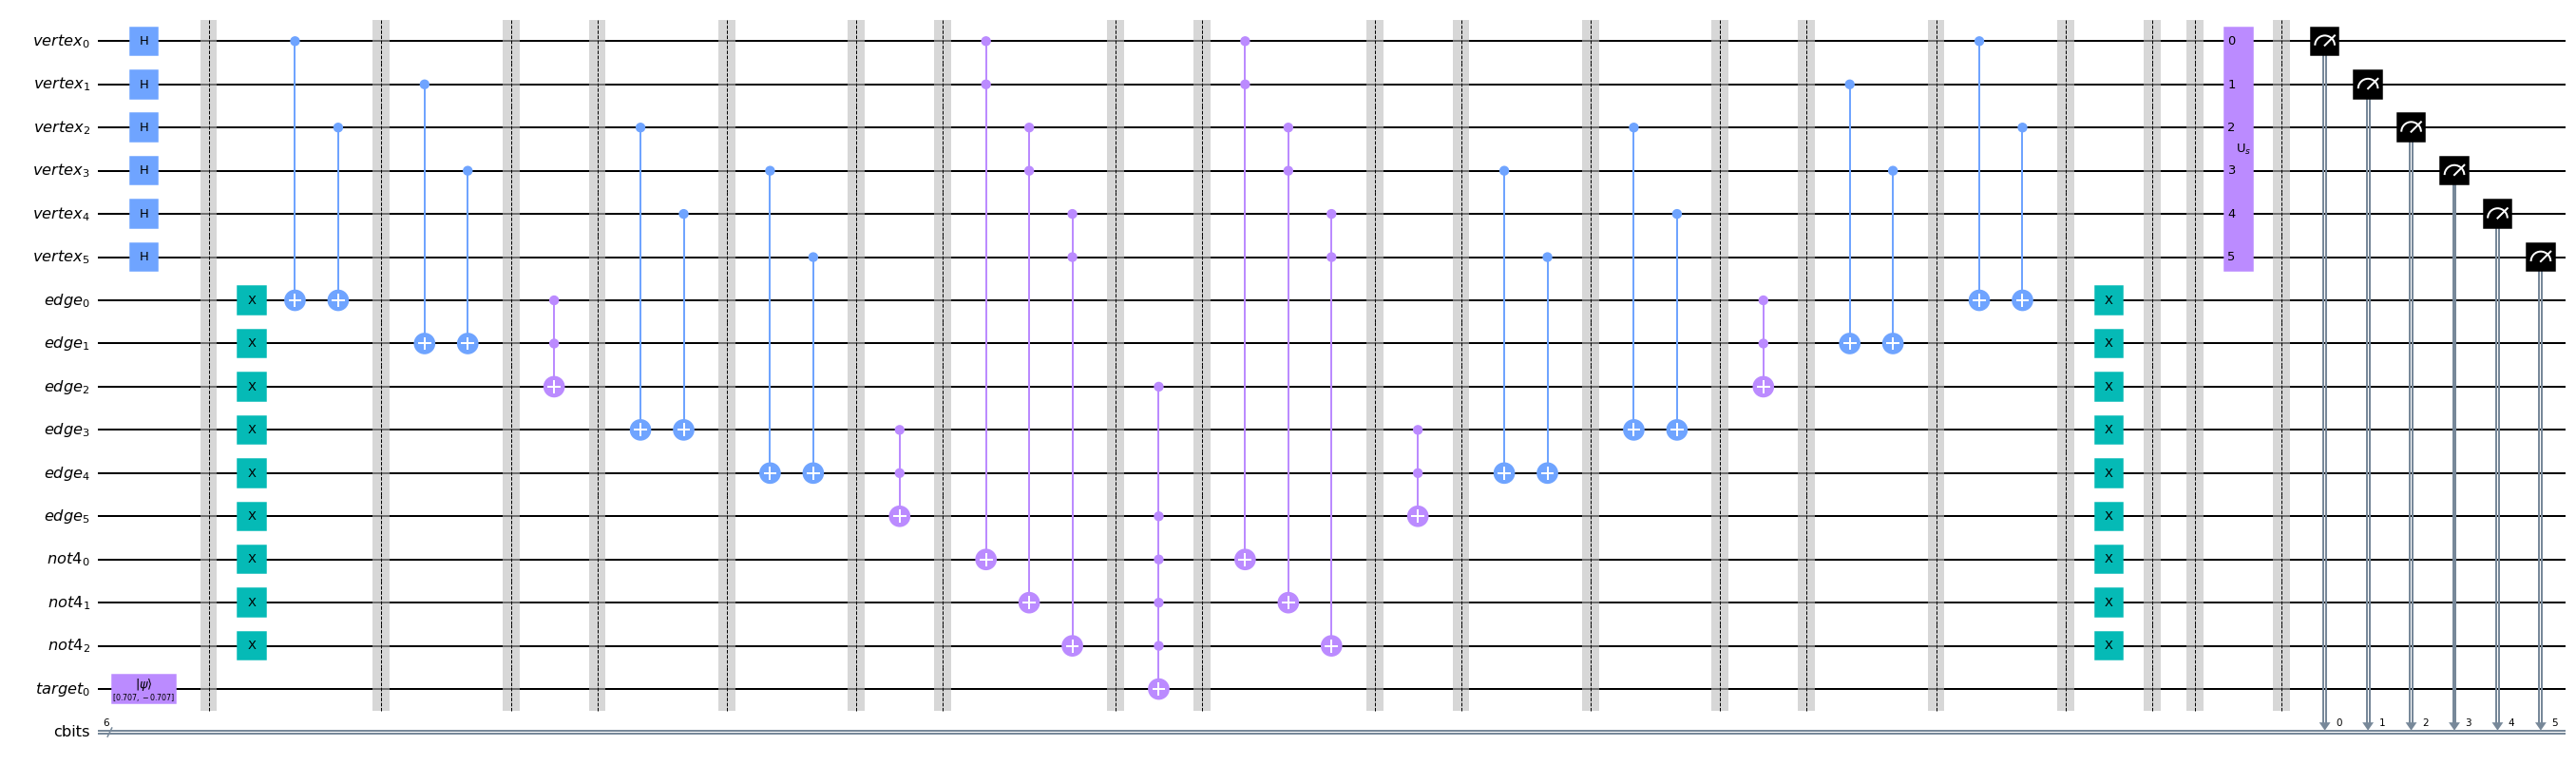

In [163]:
#example (v為vertex, e為edge)
# ex 1 
#v_list = [0,1,2,3]
#e_list = [[0,1],[1,2],[1,3], [0,1]]

#ex 2
v_list = [0,1,2]
e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 14

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取4
#xx = random.randint(1, 4)

xx = 1

for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

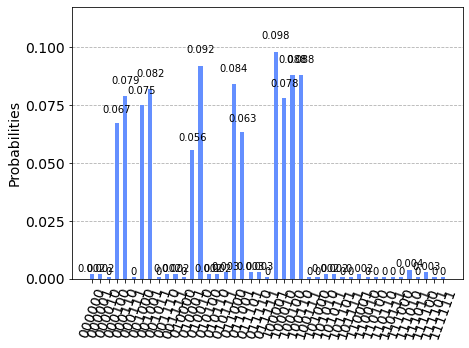

In [164]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [165]:
p1 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
#for i in range(top_n):
#        a = p1[i]
#        pause.setdefault(a[0],a[1])
#plot_histogram(pause, title="top_n",bar_labels = False)

[['100001', 100], ['010010', 94], ['100100', 90], ['100110', 90], ['011000', 86], ['001001', 84], ['000110', 81], ['100010', 80], ['001000', 77], ['000100', 69], ['011001', 65], ['010001', 57], ['111010', 4], ['111100', 3], ['010111', 3], ['011110', 3], ['011101', 3], ['001110', 2], ['010110', 2], ['110001', 2], ['010100', 2], ['101011', 2], ['000000', 2], ['001111', 2], ['101010', 2], ['000001', 2], ['011111', 1], ['101000', 1], ['110010', 1], ['111000', 1], ['111101', 1], ['110110', 1], ['000010', 1], ['110111', 1], ['101111', 1], ['000111', 1], ['010000', 1], ['111011', 1], ['001011', 1], ['100111', 1], ['110100', 1], ['111111', 1], ['101101', 1]]


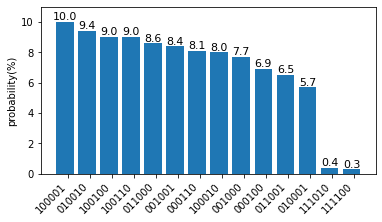

In [166]:
k = []
l = []
m = []
for i in range(top_n):
    k = p1[i]
    l.append(k[0])
    m.append(k[1]/10.0)

h = plt.bar(l,m)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, l,ha='right', rotation=45)
plt.ylabel("probability(%)")
plt.ylim(0,max(m)*1.1)
for a,b in zip(l,m):
    b2 = str(b)
    plt.text(a, b+0.005,b2 , ha='center', va= 'bottom',fontsize=11)
#'%.0d' % b    
plt.show()

In [167]:
print(counts)

{'111100': 3, '011111': 1, '101000': 1, '001110': 2, '010111': 3, '100001': 100, '110010': 1, '010110': 2, '010001': 57, '000100': 69, '000110': 81, '111010': 4, '111000': 1, '111101': 1, '011001': 65, '100100': 90, '110110': 1, '000010': 1, '110111': 1, '001001': 84, '101111': 1, '001000': 77, '100110': 90, '011110': 3, '000111': 1, '010000': 1, '111011': 1, '110001': 2, '011000': 86, '010100': 2, '011101': 3, '001011': 1, '101011': 2, '000000': 2, '100111': 1, '010010': 94, '001111': 2, '110100': 1, '101010': 2, '100010': 80, '111111': 1, '000001': 2, '101101': 1}


In [168]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'110000': 1, '101101': 1, '101111': 1, '001101': 1, '011101': 1, '110001': 1, '011100': 2, '110100': 2, '110010': 1, '010110': 2, '010010': 77, '100010': 77, '111101': 1, '011001': 83, '100100': 73, '011011': 1, '110110': 1, '110111': 1, '001001': 68, '000010': 2, '001010': 1, '101100': 2, '100101': 2, '100001': 76, '000011': 1, '010001': 69, '000100': 75, '001000': 84, '111001': 2, '100110': 78, '000101': 2, '010011': 3, '000110': 73, '111000': 3, '110101': 1, '011000': 89, '010100': 4, '100000': 6, '010101': 3, '101110': 3, '000111': 1, '100111': 3, '001110': 3, '101000': 1, '001011': 2, '000000': 3, '010111': 2, '100011': 2, '011010': 2, '101010': 2, '000001': 2, '010000': 2, '001100': 1}


In [169]:
p3 = []
pause2 = results.get_counts()
pause2.clear()
di2 = dict.fromkeys(noisy_counts)
for i in di2.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
#for i in range(top_n):
#        b = p3[i]
#        pause2.setdefault(b[0],b[1])
#plot_histogram(pause2, title="top_n",bar_labels = False)

[['011000', 89], ['001000', 84], ['011001', 83], ['100110', 78], ['010010', 77], ['100010', 77], ['100001', 76], ['000100', 75], ['100100', 73], ['000110', 73], ['010001', 69], ['001001', 68], ['100000', 6], ['010100', 4], ['010011', 3], ['111000', 3], ['010101', 3], ['101110', 3], ['100111', 3], ['001110', 3], ['000000', 3], ['011100', 2], ['110100', 2], ['010110', 2], ['000010', 2], ['101100', 2], ['100101', 2], ['111001', 2], ['000101', 2], ['001011', 2], ['010111', 2], ['100011', 2], ['011010', 2], ['101010', 2], ['000001', 2], ['010000', 2], ['110000', 1], ['101101', 1], ['101111', 1], ['001101', 1], ['011101', 1], ['110001', 1], ['110010', 1], ['111101', 1], ['011011', 1], ['110110', 1], ['110111', 1], ['001010', 1], ['000011', 1], ['110101', 1], ['000111', 1], ['101000', 1], ['001100', 1]]


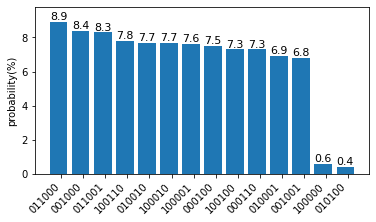

In [170]:
kk = []
ll= []
mm = []
for i in range(top_n):
    kk = p3[i]
    ll.append(kk[0])
    mm.append(kk[1]/10.0)

hh = plt.bar(ll,mm)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in hh]
plt.xticks(xticks_pos,ll,ha='right', rotation=45)
plt.ylabel("probability(%)")
plt.ylim(0,max(mm)*1.1)
for a,b in zip(ll,mm):
    b3 = str(b)
    plt.text(a, b+0.005,b3 , ha='center', va= 'bottom',fontsize=11)
#'%.0d' % b    
plt.show()

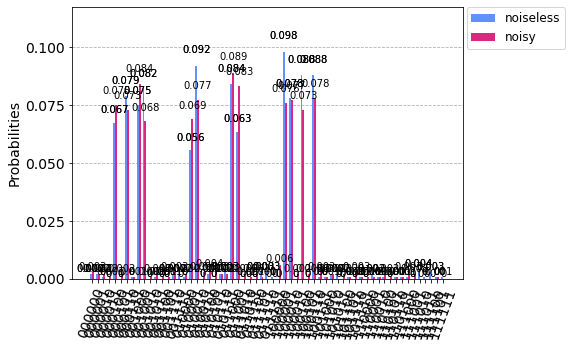

In [171]:
plot_histogram([counts, noisy_counts], legend=['noiseless', 'noisy'])

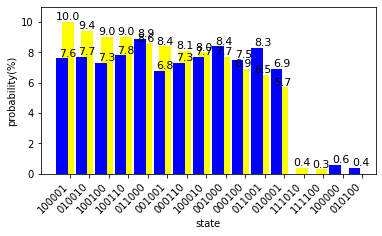

In [172]:
h1 = plt.bar(l, m,width = 0.6, color="yellow")
h2 = plt.bar(ll, mm,width = -0.6, color="blue",align = "edge")
plt.xlabel("state")
plt.ylabel("probability(%)")
plt.subplots_adjust(bottom=0.3)

plt.ylabel("probability(%)")
plt.ylim(0,max(max(m),max(mm))*1.1)
for a,b in zip(l,m):
    b4 = str(b)
    plt.text(a, b+0.005,b4 , ha='center', va= 'bottom',fontsize=11)    
for a,b in zip(ll,mm):
    b5 = str(b)
    plt.text(a, b+0.005,b5 , ha='center', va= 'bottom',fontsize=11)   
    


xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h1]

o = 0
for i in range(len(ll)):
    if (ll[i] in l):            
        o += 1
    else :
        l.append(ll[i])
        t = xticks_pos[-1] + 1.0
        xticks_pos.append(t)
     

plt.xticks(xticks_pos,l,ha='right', rotation=45)  


plt.show()